In [0]:
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Importing NumPy (Numerical Python) which is a library consisting of multidimensional array objects and a collection of routines for processing those arrays. It also gives an alias to the library.
import numpy as np

% matplotlib inline
np.random.seed(2017)

from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.callbacks import Callback
# Importing the callbacks of Keras.
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import cifar10
from keras import backend as K

In [2]:
# Mounting the Google Drive to save the weights
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
BATCH_SIZE = 256 #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 0.000125 #@param ["0.000125", "0.00025", "0.0005"] {type:"raw"}
LEARNING_RATE = 0.1 #@param ["0.4", "0.2", "0.1"] {type:"raw"}
EPOCHS = 100 #@param {type:"slider", min:0, max:100, step:1}
WARMUP = 5 #@param {type:"slider", min:0, max:24, step:1}

In [0]:
# CIFAR10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Importing CIFAR10 dataset from Keras.
from keras.datasets import cifar10

# Loading the CIFAR10 60000 Training and 10000 Test data into respective numpy arrays
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_train, n_test = X_train.shape[0], X_test.shape[0]
img_size = X_train.shape[1]
n_classes = y_train.max() + 1

In [0]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()

In [0]:
def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [0]:
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

In [0]:
def get_cutout_eraser_and_padcrop(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True, random_crop_size=(32, 32), padding_pixels=4):
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img
     
    def random_crop(input_image):
          # Note: image_data_format is 'channel_last'
          assert input_image.shape[2] == 3
          
          #Pad by 4 pixels
          img = cv2.copyMakeBorder(input_image, padding_pixels, padding_pixels, padding_pixels, padding_pixels, cv2.BORDER_REPLICATE)
          
          height, width = img.shape[0], img.shape[1]
          dy, dx = random_crop_size
          x = np.random.randint(0, width - dx + 1)
          y = np.random.randint(0, height - dy + 1)
          return img[y:(y+dy), x:(x+dx), :]
        
    def preproc_image(input_image):
      #return eraser
      return eraser(random_crop(input_image))

    return preproc_image
      
        

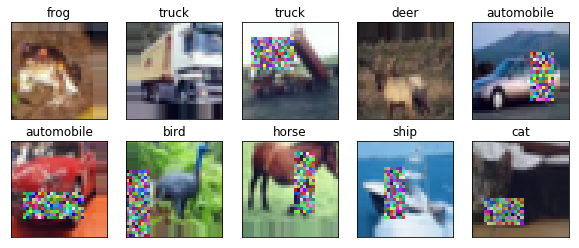

In [11]:
datagen = ImageDataGenerator(
   featurewise_center=True,
   featurewise_std_normalization=True,
   horizontal_flip=True,                 # randomly flip images                                     
   preprocessing_function=get_cutout_eraser_and_padcrop(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True))

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes = get_cifar10_labels())

In [0]:
datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.fit(X_train)
datagen_validation.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)

In [13]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))

W0731 11:03:37.580626 139780877920128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0731 11:03:37.718761 139780877920128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 11:03:37.722206 139780877920128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 11:03:37.765188 139780877920128 deprecation_wrapper.py

In [15]:
!wget "https://raw.githubusercontent.com/SomaKorada07/EIP/master/utils/clr.py"

--2019-07-31 10:21:15--  https://raw.githubusercontent.com/SomaKorada07/EIP/master/utils/clr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7928 (7.7K) [text/plain]
Saving to: ‘clr.py’

clr.py              100%[===================>]   7.74K  --.-KB/s    in 0s      

2019-07-31 10:21:17 (52.0 MB/s) - ‘clr.py’ saved [7928/7928]



In [16]:
!wget "https://raw.githubusercontent.com/SomaKorada07/EIP/master/utils/lr_finder.py"

--2019-07-31 10:21:23--  https://raw.githubusercontent.com/SomaKorada07/EIP/master/utils/lr_finder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14968 (15K) [text/plain]
Saving to: ‘lr_finder.py’

lr_finder.py        100%[===================>]  14.62K  --.-KB/s    in 0.01s   

2019-07-31 10:21:24 (1.13 MB/s) - ‘lr_finder.py’ saved [14968/14968]



In [0]:
from lr_finder import LRFinder

In [0]:
nb_epoch = 1

weights_file = 'weights/model1.h5'
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='max')

W0731 10:21:33.592635 140558010529664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



weights/losses.npy and weights/lrs.npy could not be found at directory : {weights/}


W0731 10:21:34.754428 140558010529664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
194/195 [============================>.] - ETA: 0s - loss: 0.7767 - acc: 0.7945 - LRFinder: val_loss: 2.5358 - lr = 0.00990256 
 - LRFinder: val_loss: 2.5863 - lr = 0.00995128 
195/195 [==============================] - 65s 335ms/step - loss: 0.7765 - acc: 0.7946 - val_loss: 2.5631 - val_acc: 0.3263
	LR Finder : Saved the losses and learning rate values in path : {weights/}


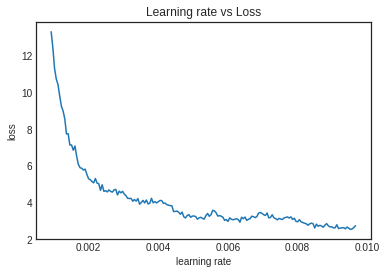

10000/10000 [==============================] - 2s 158us/step
loss : 2.5631
acc : 0.3263


In [19]:
# Exponential lr finder
# USE THIS FOR A LARGE RANGE SEARCH
# Uncomment the validation_data flag to reduce speed but get a better idea of the learning rate
#lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=1e-3, maximum_lr=10.,
                     #lr_scale='exp',
                     #validation_data=(X_test, Y_test),  # use the validation data for losses
                     #validation_sample_rate=5,
                     #save_dir='weights/', verbose=True)

# Linear lr finder
# USE THIS FOR A CLOSE SEARCH
# Uncomment the validation_data flag to reduce speed but get a better idea of the learning rate
lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=5e-4, maximum_lr=1e-2,
                      lr_scale='linear',
                      validation_data=(X_test, y_test),  # use the validation data for losses
                      validation_sample_rate=5,
                      save_dir='weights/', verbose=True)


# plot the previous values if present
LRFinder.plot_schedule_from_file('weights/', clip_beginning=10, clip_endding=5)

optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model1.load_weights('/content/gdrive/My Drive/Assignment11_083-val_acc_0.884.hdf5')

    # Fit the model on the batches generated by datagen.flow().
model1.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                        steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                        validation_data=(X_test, Y_test),
                        epochs=nb_epoch, verbose=1,
                        callbacks=[lr_finder, model_checkpoint])

lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

scores = model1.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
for score, metric_name in zip(scores, model1.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

#BEST LR IS 0.01

Epoch 1/1
194/195 [============================>.] - ETA: 0s - loss: 0.6535 - acc: 0.8168 - LRFinder: val_loss: 2.4660 - lr = 0.01981538 
 - LRFinder: val_loss: 2.5480 - lr = 0.01990769 
195/195 [==============================] - 64s 328ms/step - loss: 0.6531 - acc: 0.8169 - val_loss: 2.4458 - val_acc: 0.3441
	LR Finder : Saved the losses and learning rate values in path : {weights/momentum/momentum-0.9/}
Epoch 1/1
194/195 [============================>.] - ETA: 0s - loss: 0.6378 - acc: 0.8180 - LRFinder: val_loss: 2.2930 - lr = 0.01981538 
 - LRFinder: val_loss: 2.3212 - lr = 0.01990769 
195/195 [==============================] - 64s 329ms/step - loss: 0.6380 - acc: 0.8178 - val_loss: 2.3069 - val_acc: 0.3882
	LR Finder : Saved the losses and learning rate values in path : {weights/momentum/momentum-0.95/}
Epoch 1/1
194/195 [============================>.] - ETA: 0s - loss: 0.7000 - acc: 0.7967 - LRFinder: val_loss: 3.8678 - lr = 0.01981538 
 - LRFinder: val_loss: 3.8175 - lr = 0.0199

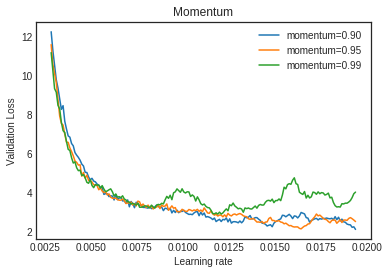

In [20]:
MOMENTUMS = [0.9, 0.95, 0.99]
nb_epoch = 1

for momentum in MOMENTUMS:
#     # Learning rate range obtained from `find_lr_schedule.py`
#     # NOTE : Minimum is 10x smaller than the max found above !
#     # NOTE : It is preferable to use the validation data here to get a correct value
      lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=0.002, maximum_lr=0.02,
                          validation_data=(X_test, Y_test),
                          validation_sample_rate=5,
                          lr_scale='linear', save_dir='weights/momentum/momentum-%s/' % str(momentum),
                          verbose=True)

#     # set the weight_decay here !
#     # lr doesnt matter as it will be over written by the callback
      optimizer = SGD(lr=0.01, momentum=momentum, nesterov=True)
      model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#         # Fit the model on the batches generated by datagen.flow().
      model1.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                             steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                             validation_data=(X_test, Y_test),
                             epochs=nb_epoch, verbose=1,
                             callbacks=[lr_finder])

# from plot we see, the model isnt impacted by the weight_decay very much at all
# so we can use any of them.

for momentum in MOMENTUMS:
    directory = 'weights/momentum/momentum-%s/' % str(momentum)

    losses, lrs = LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='momentum=%0.2f' % momentum)

plt.title("Momentum")
plt.xlabel("Learning rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

#BEST MOMENTUM IS 0.9

Epoch 1/1
194/195 [============================>.] - ETA: 0s - loss: 0.7237 - acc: 0.7886 - LRFinder: val_loss: 2.6034 - lr = 0.01981538 
 - LRFinder: val_loss: 2.5572 - lr = 0.01990769 
195/195 [==============================] - 64s 329ms/step - loss: 0.7239 - acc: 0.7886 - val_loss: 2.5807 - val_acc: 0.2995
	LR Finder : Saved the losses and learning rate values in path : {weights/weight_decay/weight_decay-1e-07/}
Epoch 1/1
194/195 [============================>.] - ETA: 0s - loss: 0.6345 - acc: 0.8196 - LRFinder: val_loss: 2.3085 - lr = 0.01981538 
 - LRFinder: val_loss: 2.4375 - lr = 0.01990769 
195/195 [==============================] - 64s 331ms/step - loss: 0.6348 - acc: 0.8195 - val_loss: 2.3922 - val_acc: 0.3635
	LR Finder : Saved the losses and learning rate values in path : {weights/weight_decay/weight_decay-3e-07/}
Epoch 1/1
194/195 [============================>.] - ETA: 0s - loss: 0.6008 - acc: 0.8309 - LRFinder: val_loss: 2.4524 - lr = 0.01981538 
 - LRFinder: val_loss: 2

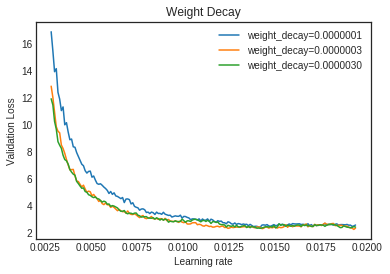

In [21]:
# INITIAL WEIGHT DECAY FACTORS
# WEIGHT_DECAY_FACTORS = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

# FINEGRAINED WEIGHT DECAY FACTORS
WEIGHT_DECAY_FACTORS = [1e-7, 3e-7, 3e-6]

for weight_decay in WEIGHT_DECAY_FACTORS:
     lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=0.002, maximum_lr=0.02,
                          validation_data=(X_test, Y_test),
                          validation_sample_rate=5,
                          lr_scale='linear', save_dir='weights/weight_decay/weight_decay-%s/' % str(weight_decay),
                          verbose=True)

#     # set the weight_decay here !
#     # lr doesnt matter as it will be over written by the callback
     optimizer = SGD(lr=0.01, momentum=0.9, nesterov=True)
     model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#
#         # Fit the model on the batches generated by datagen.flow().
     model1.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                             steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                             validation_data=(X_test, Y_test),
                             epochs=nb_epoch, verbose=1,
                             callbacks=[lr_finder])

# from plot we see, the model isnt impacted by the weight_decay very much at all
# so we can use any of them.

for weight_decay in WEIGHT_DECAY_FACTORS:
    directory = 'weights/weight_decay/weight_decay-%s/' % str(weight_decay)

    losses, lrs = LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='weight_decay=%0.7f' % weight_decay)

plt.title("Weight Decay")
plt.xlabel("Learning rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

#BEST DECAY IS 0.0000003

In [14]:
sgd = SGD(lr=0.01, decay=3e-7, momentum=0.9, nesterov=True)

# Compile the model
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

W0731 11:04:00.540922 139780877920128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# Specifying the path to store the weights
filepath="/content/gdrive/My Drive/Assignment12:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

In [0]:
from clr import OneCycleLR

lr_manager = OneCycleLR(epochs=EPOCHS, batch_size=BATCH_SIZE, samples=n_train, steps=len(train_iterator), max_lr=0.01,
                        end_percentage=0.1, scale=100,
                        maximum_momentum=0.95, minimum_momentum=0.9)

callbacks = [checkpoint, lr_manager, early_stopper]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=196, validation_data=<keras_pre..., validation_steps=20, verbose=0, callbacks=[<keras.ca..., epochs=150)`
  
W0731 11:05:38.194495 139780877920128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and w


Epoch 00001: val_acc improved from -inf to 0.34660, saving model to /content/gdrive/My Drive/Assignment12:001-val_acc:0.347.hdf5
 - lr: 0.00032 - momentum: 0.95 

Epoch 00002: val_acc improved from 0.34660 to 0.41460, saving model to /content/gdrive/My Drive/Assignment12:002-val_acc:0.415.hdf5
 - lr: 0.00054 - momentum: 0.95 

Epoch 00003: val_acc improved from 0.41460 to 0.49910, saving model to /content/gdrive/My Drive/Assignment12:003-val_acc:0.499.hdf5
 - lr: 0.00076 - momentum: 0.95 

Epoch 00004: val_acc improved from 0.49910 to 0.52110, saving model to /content/gdrive/My Drive/Assignment12:004-val_acc:0.521.hdf5
 - lr: 0.00098 - momentum: 0.95 

Epoch 00005: val_acc improved from 0.52110 to 0.55230, saving model to /content/gdrive/My Drive/Assignment12:005-val_acc:0.552.hdf5
 - lr: 0.00120 - momentum: 0.94 

Epoch 00006: val_acc improved from 0.55230 to 0.60020, saving model to /content/gdrive/My Drive/Assignment12:006-val_acc:0.600.hdf5
 - lr: 0.00142 - momentum: 0.94 

Epoch 

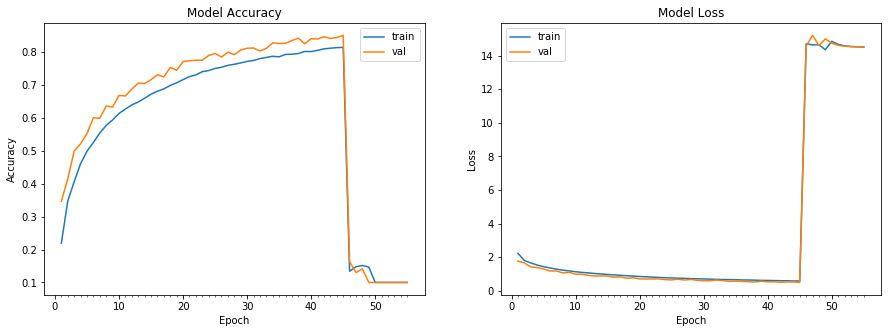

Accuracy on test data is: 10.00


In [18]:
# train the model
start = time.time()
# Train the model

model_info = model1.fit_generator(train_iterator,
                                 steps_per_epoch = len(train_iterator), nb_epoch = 150, 
                                 validation_data = validation_iterator, 
                                 validation_steps = len(validation_iterator),
                                 verbose=0, callbacks=callbacks)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

#Used EarlyStopping as last time when I run for 150 epochs, validation accuracy at 30th epoch itself was 90% but did not increase further. When I re-ran the model, this time it stopped at 85.05%.

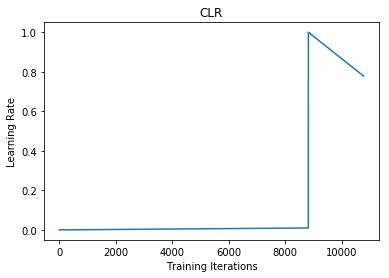

In [19]:
# Plot Learning Rate
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(lr_manager.history['lr'])
plt.show()

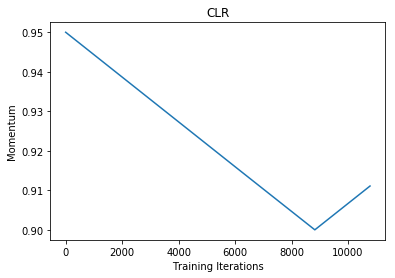

In [20]:
# Plot momentum
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("CLR")
plt.plot(lr_manager.history['momentum'])
plt.show()